# Imports

In [1]:
import os
import numpy as np
import pandas as pd
# Optional: set the device to run
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pyboostlss.model import *
from pyboostlss.distributions.MVN import *
from pyboostlss.distributions.distribution_loss_metric import *
from pyboostlss.utils import *
from pyboostlss.datasets.data_loader import load_simulated_data

import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Specifiy Distribtution

In [2]:
distribution = MVN(D=3) # Multivariate Normal, where D specifies the number of target variables

In this example, we model and predict all parameters of a trivariate Gaussian. The conditional means $\mathbf{\mu}(x)$ and the conditional covariance matrix $\mathbf{\Sigma}(x)$ are given as follows

$$
\mathbf{\mu}(x)=\begin{pmatrix}\mu_{1}(x) \\ \mu_{2}(x) \\ \mu_{3}(x)\end{pmatrix}, \qquad \qquad  
\mathbf{\Sigma}(x)= \begin{pmatrix}
\sigma^{2}_{11}(x) & \rho_{1,2}(x)\sigma_{1}(x)\sigma_{2}(x) & \rho_{1,3}(x)\sigma_{1}(x)\sigma_{3}(x) \\
\rho_{2,1}(x)\sigma_{2}(x)\sigma_{1}(x) & \sigma^{2}_{22}(x) & \rho_{2,3}(x)\sigma_{2}(x)\sigma_{3}(x) \\
\rho_{3,1}(x)\sigma_{3}(x)\sigma_{1}(x) & \rho_{3,2}(x)\sigma_{3}(x)\sigma_{2}(x) &  \sigma^{2}_{33}(x)
\end{pmatrix}
$$

Ensuring positive definiteness of the covariance matrix $\Sigma$ becomes challenging, since joint restrictions for the elements are necessary. A computationally more tractable approach to ensure positive definiteness is based on the Cholesky decomposition, that uniquely decomposes the covariance matrix as follows

$$
\mathbf{\Sigma}(x) = \mathbf{L}(x) \mathbf{L}^{\prime}(x)
$$

where $\mathbf{L}(\cdot)$ is a lower triangular matrix with positive diagonal entries. Instead of estimating the entries of $\mathbf{\Sigma}(\cdot)$ directly, Py-BoostLSS estimates the Cholesky factors $\mathbf{L}(\cdot)$ and then uses these for creating $\mathbf{\Sigma}(\cdot)$. For more details, we refer to **[März, Alexander (2022), *Multi-Target XGBoostLSS Regression*](https://arxiv.org/abs/2210.06831)**.

# Data

In [3]:
data_sim = load_simulated_data("sim_triv_gaussian.csv")

# Create 60%, 20%, 20% split for train, validation and test 
train, validate, test = np.split(data_sim.sample(frac=1,random_state=123), [int(0.6*len(data_sim)), int(0.8*len(data_sim))])

# Train
x_train = train["x"].values.reshape(-1,1)
y_train = train.filter(regex="y").values
dtrain = {"X": x_train, "y": y_train}

# Validation
x_eval = validate["x"].values.reshape(-1,1)
y_eval = validate.filter(regex="y").values
eval_sets = [{'X': x_eval, 'y': y_eval}] # Specifies eval_sets on which the model is evaluated on

# Test
x_test = test["x"].values.reshape(-1,1)
y_test = test.filter(regex="y").values

# Hyper-Parameter Optimization via Optuna

In [4]:
np.random.seed(123)

# Specifies the hyper-parameters and their value range
    # The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]
    # Currently, only the following hyper-parameters can be optimized
    
hp_dict = {"lr": [1e-3, 1],  
           "max_depth": [1, 4],
           "sketch_outputs": [1,10],
           "lambda_l2": [0, 40],     
           "colsample": [0.2, 1.0],
           "subsample": [0.2, 1.0],
           "min_gain_to_split": [0, 500]
          }  

opt_param = pyboostlss.hyper_opt(dist=distribution,
                                 params=hp_dict,
                                 dtrain=dtrain,
                                 eval_sets=eval_sets,
                                 use_hess=True, 
                                 sketch_method="proj",
                                 hp_seed=123,                # Seed for random number generator used in the Bayesian hyper-parameter search.
                                 ntrees=500,                 # Number of boosting iterations.
                                 es=20,                      # Early stopping rounds
                                 n_trials=50,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                                 max_minutes=120,            # Time budget in minutes, i.e., stop study after the given number of minutes.
                                 silence=False)              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

[I 2022-12-05 12:53:16,460] A new study created in memory with name: Py-BoostLSS Hyper-Parameter Optimization
C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\pyboost\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/50 [00:00<?, ?it/s]

[12:53:23] Stdout logging level is INFO.
[12:53:23] GDBT train starts. Max iter 500, early stopping rounds 20
[12:53:25] Iter 0; Sample 0, NLL-score = 9176.23200749895; 
[12:53:31] Early stopping at iter 86, best iter 66, best_score 7150.972203020752
[I 2022-12-05 12:53:31,364] Trial 0 finished with value: 7150.97216796875 and parameters: {'lr': 0.5605976584742175, 'max_depth': 4, 'sketch_outputs': 1, 'lambda_l2': 8.125403616631655, 'colsample': 0.606262867277662, 'subsample': 0.6447004814948847, 'min_gain_to_split': 224.0643041445496}. Best is trial 0 with value: 7150.97216796875.
[12:53:31] Stdout logging level is INFO.
[12:53:31] GDBT train starts. Max iter 500, early stopping rounds 20
[12:53:31] Iter 0; Sample 0, NLL-score = 8604.834479917325; 
[12:53:34] Early stopping at iter 44, best iter 24, best_score 7272.111076333547
[I 2022-12-05 12:53:34,395] Trial 1 finished with value: 7272.111328125 and parameters: {'lr': 0.7225739525097444, 'max_depth': 3, 'sketch_outputs': 10, 'lambd

# Model Training

In [5]:
opt_params = opt_param.copy()

pyboostlss_model = pyboostlss.train(dist=distribution, 
                                    dtrain=dtrain,
                                    lr=opt_params["lr"], 
                                    lambda_l2=opt_params["lambda_l2"],
                                    max_depth=opt_params["max_depth"],
                                    sketch_outputs=opt_params["sketch_outputs"],
                                    colsample=opt_params["colsample"],
                                    subsample=opt_params["subsample"],
                                    min_gain_to_split=opt_params["min_gain_to_split"],
                                    ntrees=opt_params["opt_rounds"],
                                    use_hess=True,
                                    verbose=100,                                
                                    sketch_method="proj",
                                    seed=123)

[13:09:09] Stdout logging level is INFO.
[13:09:09] GDBT train starts. Max iter 295, early stopping rounds 100
[13:09:09] Iter 0; 
[13:09:15] Iter 100; 
[13:09:21] Iter 200; 
[13:09:27] Iter 294; 


# Predict

In [6]:
# Predicts transformed parameters of the specified distribution. Py-BoostLSS returns the elements of the covariance matrix, instead of the Cholesky factors.
predt_params = distribution.predict(model=pyboostlss_model,
                                    X_test=x_test,
                                    pred_type="parameters")

predt_params

,location_1,location_2,location_3,scale_1,scale_2,scale_3,rho_21,rho_31,rho_32
0,0.206260,1.202351,0.994340,0.609554,1.552440,1.236926,0.724164,0.273854,0.705377
1,-0.191019,0.464402,1.472969,0.682328,1.832538,1.753479,0.908976,0.649364,0.584485
2,0.515328,0.552790,1.799130,0.951862,1.700126,1.007845,0.689904,0.690097,0.434478
3,0.363532,0.542991,1.631046,0.882850,1.376945,1.000755,0.912777,0.661823,0.476048
4,0.126098,0.668554,1.844255,0.804212,1.685713,1.414052,0.755679,0.739009,0.525814
...,...,...,...,...,...,...,...,...,...
1995,0.063697,0.074068,1.018890,0.636350,1.042801,1.117157,0.912888,0.553997,0.718645
1996,-0.189724,0.462940,1.471884,0.684680,1.825769,1.743588,0.908186,0.648851,0.584701
1997,0.515328,0.552790,1.799130,0.951862,1.700126,1.007845,0.689904,0.690097,0.434478
1998,0.140277,1.302536,0.972343,0.621926,1.494756,1.268229,0.725742,0.276484,0.699875


In [7]:
# Draws random samples from the predicted distribution
torch.manual_seed(123)
predt_samples = distribution.predict(model=pyboostlss_model,
                                     X_test=x_test,
                                     pred_type="samples",   
                                     n_samples=1000)

predt_samples.shape # Output shape is (n_samples, n_obs, n_target)

(1000, 2000, 3)

# Plot

In the following, we compare the true moments of the multivariate Gaussian with the ones predicted by Py-BoostLSS.

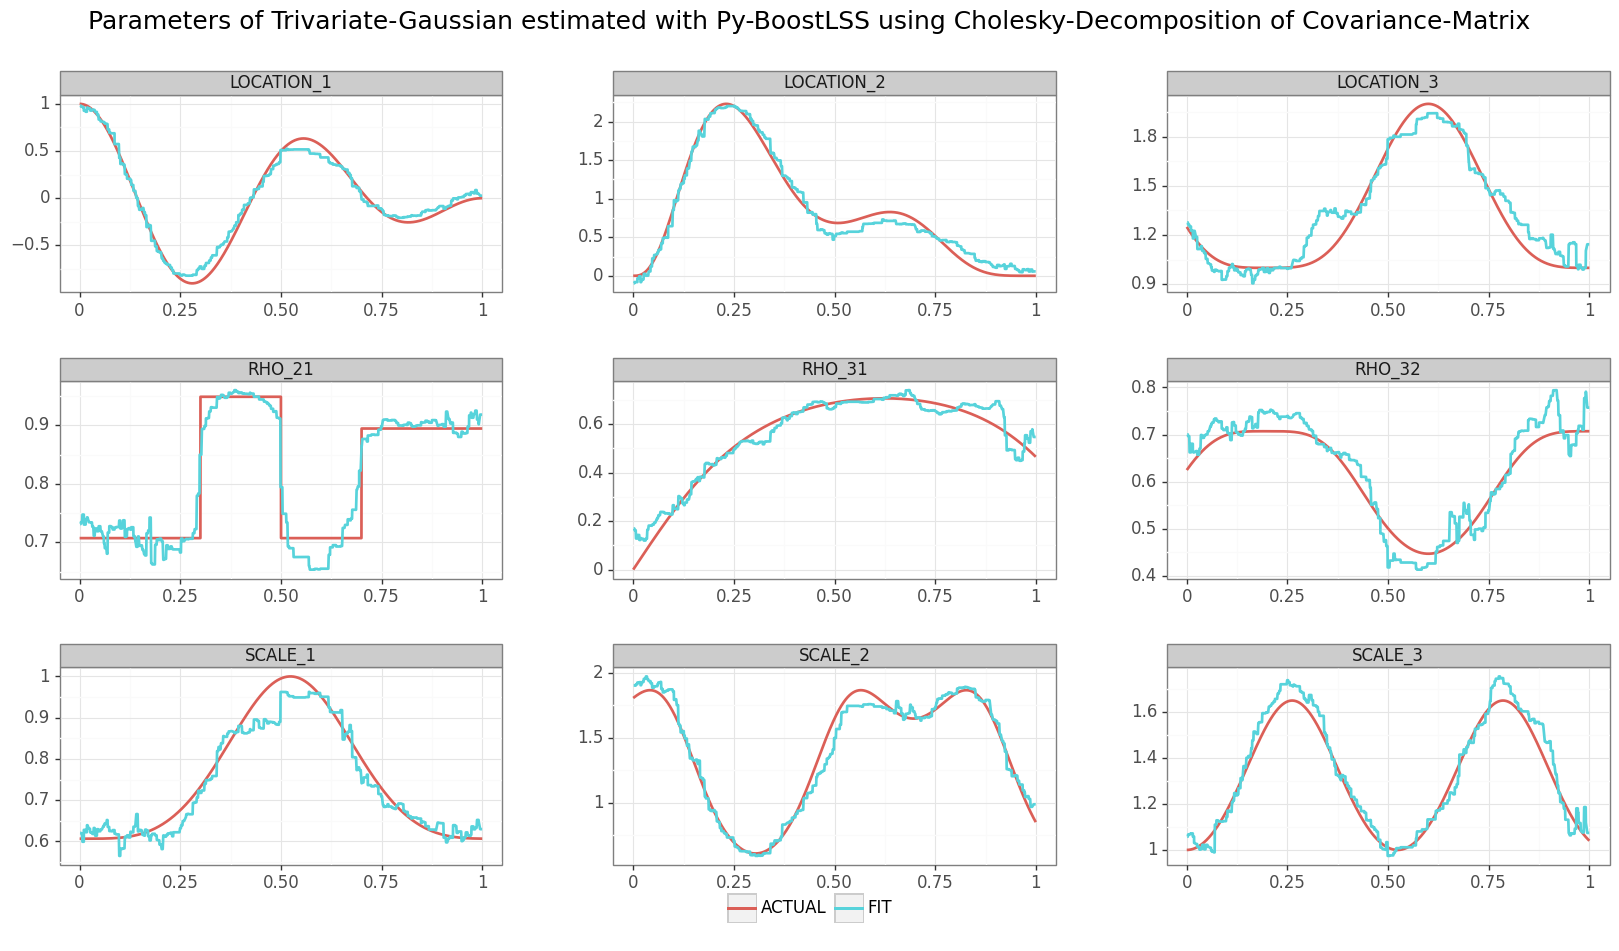

In [8]:
predt_params["x"] = x_test
dist_params = list(predt_params.columns)
drop_cols = [resp for resp in list(data_sim.columns) if "y" in resp]

# Data with actual values
plot_df_actual = pd.melt(data_sim.drop(columns=drop_cols, axis=0),
                         id_vars="x",
                         value_vars=dist_params)
plot_df_actual["type"] = "ACTUAL"

# Data with predicted values
plot_df_predt = pd.melt(predt_params,
                        id_vars="x",
                        value_vars=dist_params)
plot_df_predt["type"] = "FIT"

plot_df = pd.concat([plot_df_actual, plot_df_predt])   

plot_df["variable"] = plot_df.variable.str.upper()


plot_params = (ggplot(plot_df,
                      aes(x="x",
                          y="value",
                          color="type")) +
               geom_line(size=1.1) + 
               facet_wrap("variable",
                          scales="free") + 
               labs(title="Parameters of Trivariate-Gaussian estimated with Py-BoostLSS using Cholesky-Decomposition of Covariance-Matrix\n",
                    x="",
                    y="") + 
               theme_bw(base_size=15) + 
               theme(legend_position="bottom",
                     legend_title = element_blank(),
                     subplots_adjust={"wspace": 0.25,
                                      "hspace": 0.45})
              )


print(plot_params)

We find that Py-BoostLSS approximates well the true shape of the moments of the trivariate Gaussian.